In [1]:
using Gen, Plots, Images, Colors

In [2]:
# Global vars
IMG_SIZE = 100;

In [3]:
# See if should be static compiled for inference efficiency
@gen function scene()
    # Defining how many objects are in the scene
    n_objects ~ poisson(3)
    n_objects += 1 # Making sure at least 1 object

    shape_universe = ["square", "circle", "star"]
    color_universe = ["red", "yellow", "green"]

    # Should probably make this a passed in param
    
    objects = []
    for i = 1:n_objects

        shape_idx = {(:shape, i)} ~ uniform_discrete(1,3)
        shape = shape_universe[shape_idx]

        color_idx = {(:color, i)} ~ uniform_discrete(1,3)
        color = color_universe[color_idx]

        x = {(:x, i)} ~ uniform_discrete(1, IMG_SIZE)
        y = {(:y, i)} ~ uniform_discrete(1, IMG_SIZE)
        
        push!(objects, (shape, color, (x, y)))
    end
    
    return objects
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##scene#292", Bool[], false)

In [4]:
# Drawing utilities

# colors
color_map = Dict("red" => (1.0, 0.0, 0.0), "yellow" => (1.0, 1.0, 0.0), "green" => (0.0, 1.0, 0.0))

# shapes
function draw_square!(img, center, size, color)
    x, y = center
    half_size = size ÷ 2
    for dx in -half_size:half_size, dy in -half_size:half_size
        nx, ny = x + dx, y + dy
        if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
            img[ny, nx] = color
        end
    end
end

# Function to draw a circle
function draw_circle!(img, center, radius, color)
    x, y = center
    for dx in -radius:radius, dy in -radius:radius
        if dx^2 + dy^2 <= radius^2
            nx, ny = x + dx, y + dy
            if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
                img[ny, nx] = color
            end
        end
    end
end

shape_map = Dict("square" => draw_square!, "circle" => draw_circle!, "star" => draw_square!)

Dict{String, Function} with 3 entries:
  "circle" => draw_circle!
  "star"   => draw_square!
  "square" => draw_square!

In [13]:
function to_display_img(img_matrix)
    return [RGB(img_matrix[i, j]...) for i in 1:IMG_SIZE, j in 1:IMG_SIZE]
end

function render(objects, show_img=false)
    img = fill((1.0,1.0,1.0), IMG_SIZE, IMG_SIZE)
    for (shape, color, center) in objects
        shape_map[shape](img, center, 10, color_map[color])
    end
    if show_img
        display(to_display_img(img))
    end
    return img
    end

function render_trace(trace, show_img=false)
    objects = get_retval(trace)
    render(objects, show_img)
    end

render_trace (generic function with 2 methods)

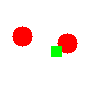

In [14]:
render_trace(Gen.simulate(scene, ()), true);

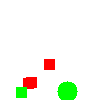

In [15]:
# Experimenting w/ constraints
constraints = Gen.choicemap()
constraints[:n_objects] = 4
(trace, _) = Gen.generate(scene, (), constraints)
render_trace(trace, true);

In [16]:
# TODO (Zack) when write the inference code make sure that we divide the actual 
# overlap by the total potential overlap -- also only take the overlap of the non-white elements

In [190]:
# Image observation distribution
struct ObservationMixture <: Distribution{Matrix{Tuple{Float64, Float64, Float64}}} end

function Gen.random(::ObservationMixture)
    return render(scene())
end

function Gen.logpdf(::ObservationMixture,
        Y::Matrix{Tuple{Float64, Float64, Float64}},
        X::Matrix{Tuple{Float64, Float64, Float64}})

    blank = fill((1.0,1.0,1.0), size(X))
    obs_non_background = .!(Y .== blank)
    input_non_background = .!(X .== blank)

    intersection = sum(obs_non_background .& input_non_background)
    normalizer = sum(input_non_background)

    return log(intersection) - log(normalizer)
end

In [197]:
obs_mixture = ObservationMixture()
Y = random(obs_mixture)
X = random(obs_mixture)
exp(logpdf(obs_mixture, Y, X))

0.0351145038167939

In [199]:
@gen function img_model()
    img ~ random(ObservationMixture())
    return img
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##img_model#297", Bool[], false)

In [187]:
img_model()

LoadError: MethodError: no method matching traceat(::Gen.GFUntracedState, ::typeof(random), ::Tuple{ObservationMixture}, ::Symbol)

[0mClosest candidates are:
[0m  traceat(::Gen.GFUntracedState, [91m::GenerativeFunction[39m, ::Any, ::Any)
[0m[90m   @[39m [35mGen[39m [90m~/.julia/packages/Gen/ME5el/src/dynamic/[39m[90m[4mdynamic.jl:84[24m[39m
[0m  traceat(::Gen.GFUntracedState, [91m::Distribution[39m, ::Any, ::Any)
[0m[90m   @[39m [35mGen[39m [90m~/.julia/packages/Gen/ME5el/src/dynamic/[39m[90m[4mdynamic.jl:87[24m[39m
[0m  traceat([91m::Gen.GFProposeState[39m, [91m::Distribution{T}[39m, ::Any, ::Any) where T
[0m[90m   @[39m [35mGen[39m [90m~/.julia/packages/Gen/ME5el/src/dynamic/[39m[90m[4mpropose.jl:12[24m[39m
[0m  ...


In [ ]:
# Example inference procedure
function do_inference(model, xs, ys, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;